# Final Project Scientific Python - Fall 2021

**Student**: Vania Buso

**Department**: Medieval Studies

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time
import re
import requests
from lxml import etree, html
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import numpy as np
import matplotlib as mpl
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from feature_engine.creation import CyclicalTransformer

### 1. Introduction

Fanfictions, i.e., stories written pre-date by fans based on characters, universes etc. from popular culture, pre-date the Internet (Jenkins, 1992). Nowadays, fanfictions are mostly published online on dedicated platforms and are closely related to the activities and interactions within and among fan communities online. In other words, fanfictions mirror trends in fandoms, i.e., fan-cultures. For example, scholars have identified queering trends directed at specific popular culture franchise such as Harry Potter (MacDonald, 2006; Lothian, 2018; Floegel, 2020).

This notebook gathers and briefly explores the metadata of a sample of fanfictions from the online publishing platform Archive of Our Own (AO3 from now on). The scope is to find the best ML algorithm to predict the success of a fanfiction. The data will be processed manually and the features selected more with the idea of simplifying the model and experiment with feature engineering rather than with rigorous feature engineering methods. As a result, the selection of features is not going to be the best one. Rather, it strives to include categorical, numerical and datetime variables in the same ML model.

The sample is fandom specific. The notebook will only deal with data from the macro-fandom "TOLKIEN J.R.R. - All Works & Related Media", which comprises of the biggest fandom inspired by the works of Tolkien. This fandom should encompass stories from all media types (movies, books, cartoons etc.) inspired by Tolkien's works. 

### 2. Basic data description and scraping

#### 2.1. Metadata definition

The dataset batch utilized comprises of all the crossover fanfictions contained in "TOLKIEN J.R.R. - All Works & Related Media" as of December 26th, 2021. The data was scraped with a custom procedural-styled scraper by starting from an initial url. The parameters of the search inputted in the [search page](https://archiveofourown.org/works/search) are the following:

1. Completion status: "Complete"
2. Crossover: "Only crossover"
3. Fandoms: "TOLKIEN J.R.R. - All Works & Related Media"
4. Sort by: "Date Updated"
5. Sort direction: "Ascending"

All the metadata available for each story as displayed in the result pages was gathered and collected into a .csv file. A few notes of caution on the metadata and the design of the scraper:

1. Most tags are optional or, sometimes, if they are required, their number is optional (though there is usually a maximum limit);


2. Some tags might not be visible in the data (i.e., they are denoted by a nan value) because the scraping was not carried out with an official permission. This data might be visible with such a permission or through an AO3 account.  


### 3. EDA

#### 3.1. Preliminary insights and definition of fanfiction success

In [2]:
#scraping on December 26th, 2021
tolkien_url = "https://archiveofourown.org/works/search?utf8=%E2%9C%93&work_search%5Bquery%5D=&work_search%5Btitle%5D=&work_search%5Bcreators%5D=&work_search%5Brevised_at%5D=&work_search%5Bcomplete%5D=T&work_search%5Bcrossover%5D=T&work_search%5Bsingle_chapter%5D=0&work_search%5Bword_count%5D=&work_search%5Blanguage_id%5D=&work_search%5Bfandom_names%5D=TOLKIEN+J.+R.+R.+-+Works+%26+Related+Fandoms&work_search%5Brating_ids%5D=&work_search%5Bcharacter_names%5D=&work_search%5Brelationship_names%5D=&work_search%5Bfreeform_names%5D=&work_search%5Bhits%5D=&work_search%5Bkudos_count%5D=&work_search%5Bcomments_count%5D=&work_search%5Bbookmarks_count%5D=&work_search%5Bsort_column%5D=revised_at&work_search%5Bsort_direction%5D=asc&commit=Search"
ao3_metadata_by_page_to_csv(tolkien_url, "fanfic_metadata_crossover.csv") 

The data batch used for this analysis comprises of 3816 stories, and each story is described by 21 different variables. 

In [2]:
df = pd.read_csv('fanfic_metadata_crossover_2612 - fanfic_metadata_crossover_2612.csv', encoding = 'utf-8')
print("DataFrame dimensions:", df.shape)
print("Number of stories:", df['ids'].nunique())
print("Metadata variables:", df.columns.values)

DataFrame dimensions: (17253, 21)
Number of stories: 3816
Metadata variables: ['ids' 'titles' 'authors' 'crossover_fandoms' 'ratings' 'warnings'
 'pairings' 'completion_status' 'dates_completion' 'freeform_tags'
 'add_warnings' 'relationships' 'characters' 'summaries' 'word_counts'
 'n_chapters' 'n_kudos' 'n_comments' 'n_bookmarks' 'languages' 'n_hits']


Because of the regular updates to AO3, there might be duplicate entries in the dataset. However, in this specific batch of data downloaded, there appear to be no duplicates. 

In [3]:
def check_duplicates(df):
    duplicates = df.duplicated()
    if any(duplicates) == True:
        print("Some duplicates in the dataset")
    else:
        print("No duplicates in the dataset")

In [4]:
check_duplicates(df)

No duplicates in the dataset


In [10]:
df.head()

,ids,authors,crossover_fandoms,ratings,warnings,pairings,dates_completion,freeform_tags,relationships,characters,word_counts,n_chapters,n_kudos,n_comments,n_bookmarks,languages,n_hits
0,102813,Jennifer Gail (lferion),J.R.R.Tolkien - Works,General Audiences,No Archive Warnings Apply,Gen,1988-11-10,Poetry,<NA>,<NA>,208,1,9,2,1,English,423
1,102813,Jennifer Gail (lferion),Original Work,General Audiences,No Archive Warnings Apply,Gen,1988-11-10,Poetry,<NA>,<NA>,208,1,9,2,1,English,423
2,546730,Serriya (Keolah),TOLKIEN J. R. R. - Works,General Audiences,No Archive Warnings Apply,Gen,1995-01-01,Family,<NA>,Original Characters,1326,1,2,<NA>,1,English,152
3,546730,Serriya (Keolah),Dungeons & Dragons - Fandom,General Audiences,No Archive Warnings Apply,Gen,1995-01-01,Family,<NA>,Original Characters,1326,1,2,<NA>,1,English,152
4,133466,Wander Riordan (lferion),20th Century CE RPF,General Audiences,No Archive Warnings Apply,Gen,1995-05-28,Poetry,<NA>,<NA>,494,1,<NA>,<NA>,<NA>,English,183


The scraper retrieved all the metadata available for the stories in the html code of AO3 pages. Nevertheless, some of the variables can be excluded a priori from the analysis:

1. 'summaries': it would need additional textual processing before becoming useful for an ML model;
2. 'titles': it would need additional textual processing before becoming useful for an ML model;
3. 'completion_status': all the stories collected are 'complete', which means that the ML model is by default modelled on completed stories;
4. 'add_warnings': there's already a variable for warnings displayed in the dataset, which should suffice for the ML model.

Therefore, these variables can be dropped.

In [5]:
df = df.drop(columns = ["summaries", "titles", "completion_status", "add_warnings"])

Further variables will be excluded as the analysis proceeds.

The scraper handled the first step in the data cleaning by getting rid of the list values throught the df.explode() method. This created additional rows for stories with list values that contained multiple elements. Nevetheless, the string values have been stored as objects instead of strings. 

In [6]:
df.dtypes

ids                    int64
authors               object
crossover_fandoms     object
ratings               object
warnings              object
pairings              object
dates_completion      object
freeform_tags         object
relationships         object
characters            object
word_counts          float64
n_chapters             int64
n_kudos              float64
n_comments           float64
n_bookmarks          float64
languages             object
n_hits                 int64
dtype: object

This is an inconvenient format because at a later stage of the analysis some of these values will need to be manipulated. Therefore it is necessary to convert these into string. By using convert_dtypes() with the default parameters, pandas will also conveniently infer int64 instead of float64 for the numeric values, which are all integers.

In [7]:
df = df.convert_dtypes()

For later convenience, the variable 'dates_completion' will also be already converted to a datetime object.

In [8]:
df["dates_completion"] = pd.to_datetime(df["dates_completion"], format = "%d %b %Y")

In [9]:
df.dtypes

ids                           Int64
authors                      string
crossover_fandoms            string
ratings                      string
warnings                     string
pairings                     string
dates_completion     datetime64[ns]
freeform_tags                string
relationships                string
characters                   string
word_counts                   Int64
n_chapters                    Int64
n_kudos                       Int64
n_comments                    Int64
n_bookmarks                   Int64
languages                    string
n_hits                        Int64
dtype: object

 Intuitively, the success of a fanfiction can be assessed based on the number of kudos, number of bookmarks, number of comments and number of hits of a fanfiction. The number of 'NaN' values for each story will indicate the most reliable categories to define the success of a story. As it can be seen, all these variables save for the number of hits present some NaN values.

In [11]:
print("Overall number of nan values by df column:\n", df.isnull().sum())

Overall number of nan values by df column:
 ids                     0
authors                81
crossover_fandoms       0
ratings                 0
warnings                0
pairings                0
dates_completion        0
freeform_tags        1773
relationships        5997
characters           2252
word_counts             3
n_chapters              0
n_kudos              1132
n_comments           5031
n_bookmarks          5960
languages               0
n_hits                  0
dtype: int64


This print only shows that there are some 'NaN' values for the most of the fields that interest us, but it does not give us any idea of the actual proportion of NaN values with regards to the stories. For a closer look at these nan values, however, it is necessary to group the stories by their id (multiple entries have the same id).

In [12]:
nan_kudos = df["n_kudos"].isnull().groupby(df["ids"]).sum()
#print("Stories with 'NaN' values for 'n_kudos':", (nan_kudos[nan_kudos >= 1].index).tolist()) #optional print
#print()
print("Number of stories with 'Nan' values for 'n_kudos': {}, i.e., {: .2f}% of stories.".format(
    len((nan_kudos[nan_kudos >= 1].index).tolist()), 
    100*len((nan_kudos[nan_kudos >= 1].index).tolist())/df["ids"].nunique()))

Number of stories with 'Nan' values for 'n_kudos': 176, i.e.,  4.61% of stories.


In [13]:
nan_comments = df["n_comments"].isnull().groupby(df["ids"]).sum()
#print("Stories with 'NaN' values for 'n_comments':", (nan_comments[nan_comments >= 1].index).tolist()) #optional print
#print()
print("Number of stories with 'Nan' values for 'n_comments': {}, i.e., {: .2f}% of stories.".format(
    len((nan_comments[nan_comments >= 1].index).tolist()), 
    100*len((nan_comments[nan_comments >= 1].index).tolist())/(df["ids"].nunique())))

Number of stories with 'Nan' values for 'n_comments': 1141, i.e.,  29.90% of stories.


In [14]:
nan_bookmarks = df["n_bookmarks"].isnull().groupby(df["ids"]).sum()
#print("Stories with 'NaN' values for 'n_bookmarks':", (nan_bookmarks[nan_bookmarks >= 1].index).tolist()) #optional print
#print()
print("Number of stories with 'Nan' values for 'n_bookmarks': {}, i.e., {: .2f}% of stories.".format(
    len((nan_bookmarks[nan_bookmarks >= 1].index).tolist()), 
    100*len((nan_bookmarks[nan_bookmarks >= 1].index).tolist())/df["ids"].nunique()))

Number of stories with 'Nan' values for 'n_bookmarks': 1273, i.e.,  33.36% of stories.


The proportion of NaN values for both bookmarks and comments is quite high.

Because of the high percentage of missing values in both n_comments and n_bookmarks and to simplify the ML model, the variables 'n_bookmarks' and 'n_comments' will be excluded from the analysis.

In [15]:
df = df.drop(columns = ["n_bookmarks", "n_comments"])

#### 3.2. Additional features: stories' position within the network 

The connections of a story to fandoms matter for its success. In order to assess a story's relevance within the stories network of the selected fandom, I have taken into consideration the projection onto the fanfictions' node set of the bipartite network representing the connections fanfictions - fandoms. 

The fanfiction - fandom network is a bipartite, undirected graph. One set of nodes represents fanfictions, and the other represents fandoms.

In [16]:
nodes_fanfictions = list(df["ids"].unique()) #first group of the bipartite network
nodes_fandoms = list(df["crossover_fandoms"].dropna().unique())

Edges are created between a fanfiction and a fandom if the fandom is mentioned in the fandom tag of the fanfiction.

In [17]:
edge_list_bip_fanfic_fand = list((df[["ids", "crossover_fandoms"]]).to_records(index = False))

In [18]:
bip_fanfic_fand = nx.Graph()

The visualization of the network is not very telling given the amount of nodes and edges.

In [19]:
bip_fanfic_fand.add_nodes_from(nodes_fanfictions, bipartite = 0, category = "fanfiction", color = "#1AFF1A" )
bip_fanfic_fand.add_nodes_from(nodes_fandoms, bipartite = 1, category = "fandom", color = "#4B0092")
bip_fanfic_fand.add_edges_from(edge_list_bip_fanfic_fand)

In [20]:
pos_bip = nx.bipartite_layout(bip_fanfic_fand, nodes_fanfictions)

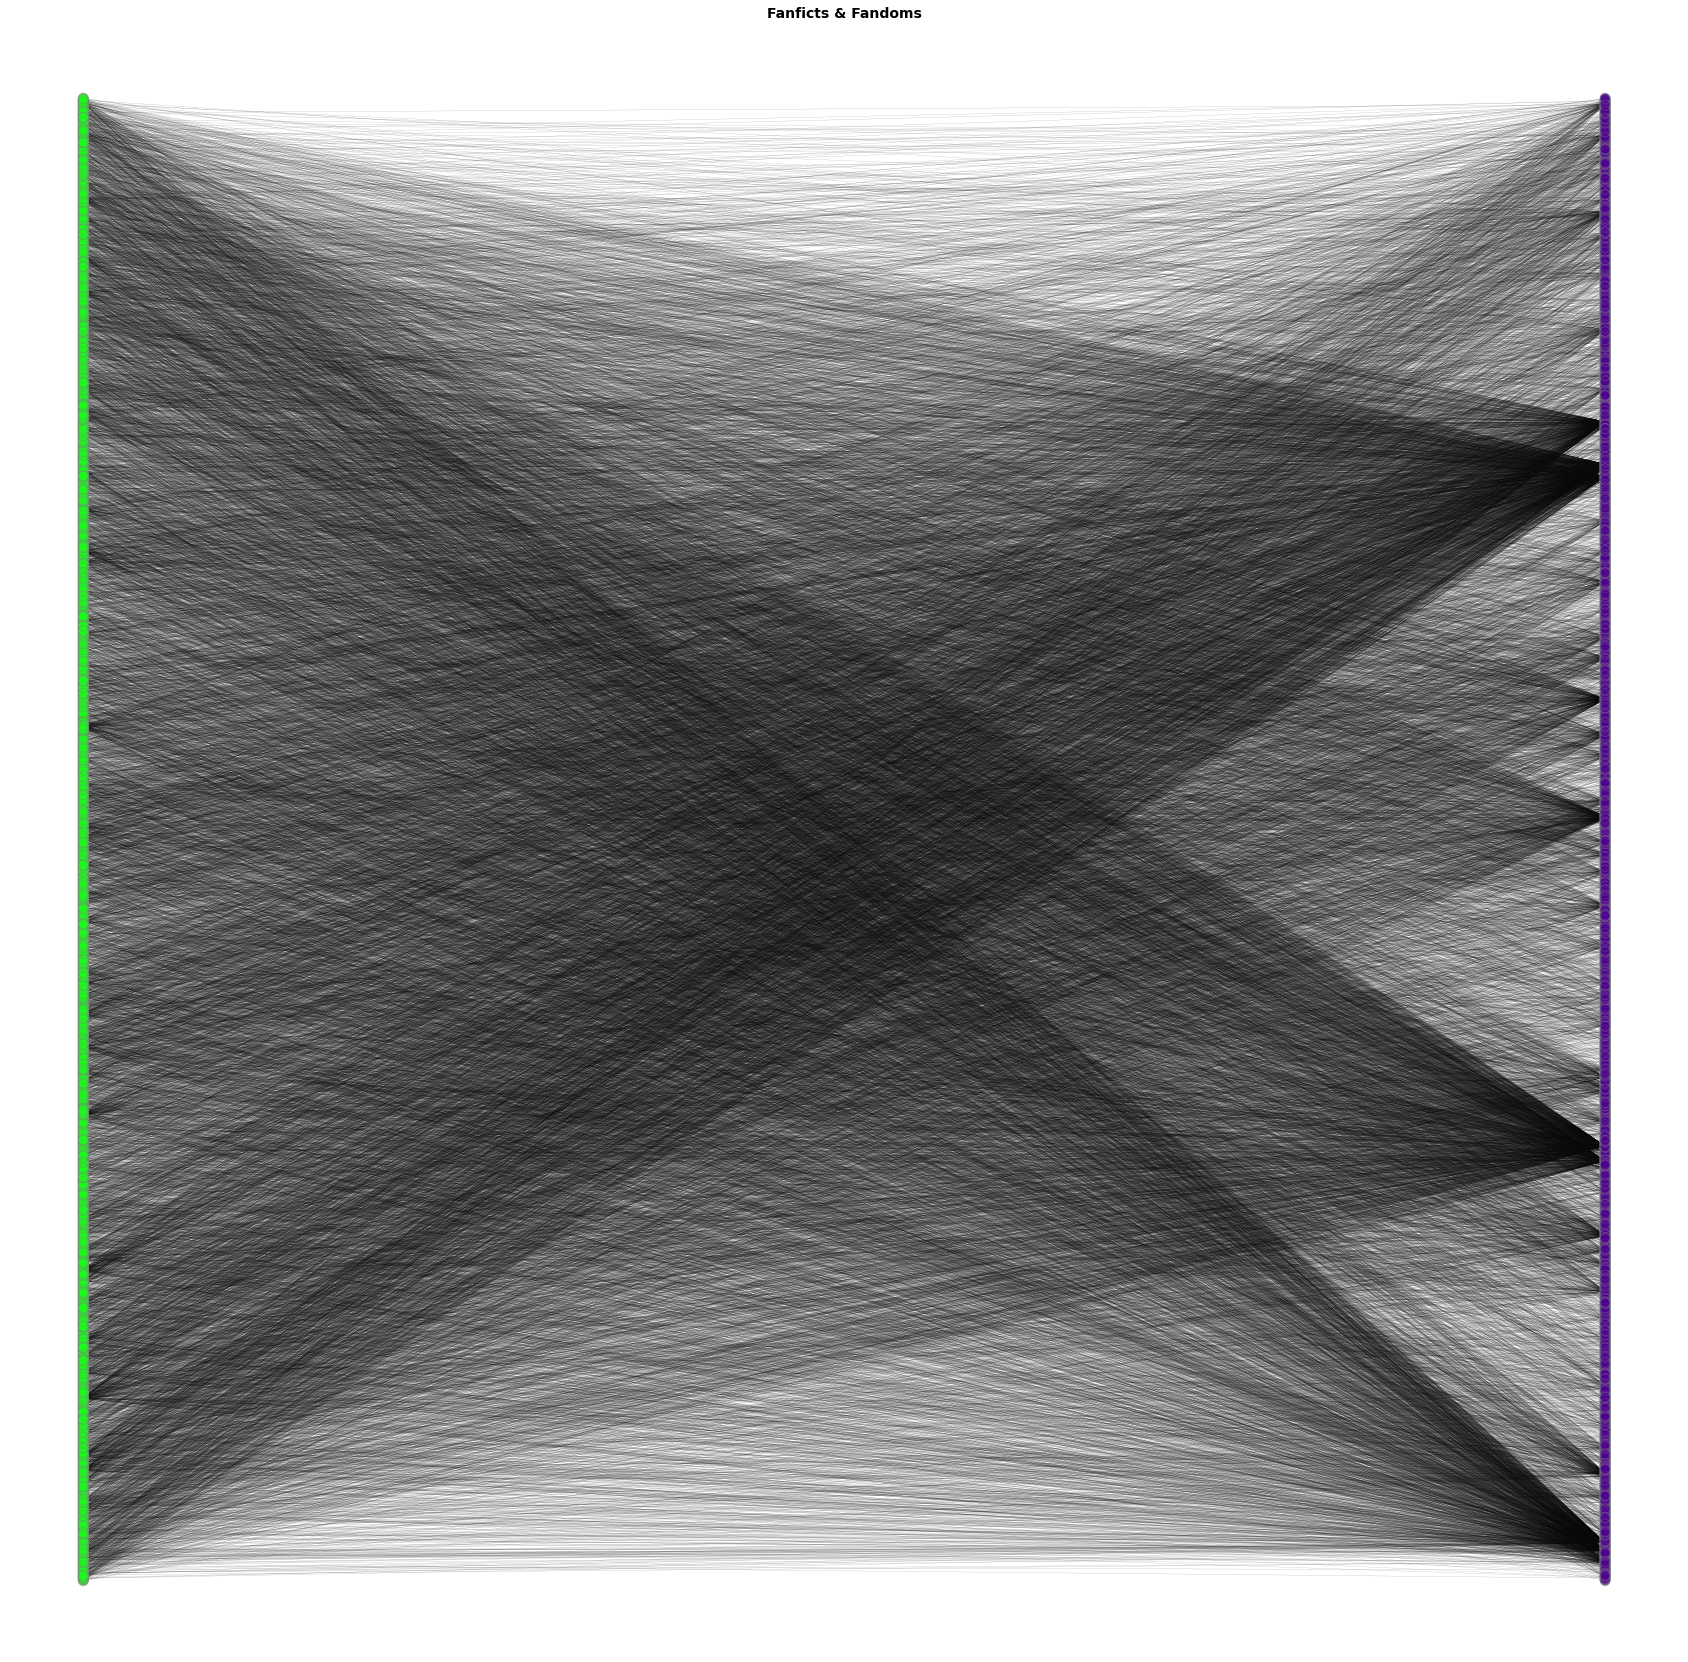

In [21]:
fig = plt.figure(figsize = (30, 30))
plt.title("Fanficts & Fandoms", fontsize = 14, weight = "bold")
nx.draw_networkx(bip_fanfic_fand, pos = pos_bip, node_size = 100, width = .2, with_labels = False, node_color = list(nx.get_node_attributes(bip_fanfic_fand, "color").values()), edgecolors = "#808080", alpha = .4)
plt.axis("off");

Nevertheless, to gauge the position of a story within the fanfictions' network, the projection onto the fanfiction network of the bipartite network must be constructed. This is a unipartite undirected network. 

In [22]:
proj_bip_fanfic_fand = bipartite.projected_graph(bip_fanfic_fand, nodes_fanfictions)

In [23]:
pos_proj_bip = nx.kamada_kawai_layout(proj_bip_fanfic_fand)

In [24]:
fig = plt.figure(figsize = (10, 10))
plt.title("Fanficts Network", fontsize = 14, weight = 'bold')
nx.draw_networkx(proj_bip_fanfic_fand, pos = pos_proj_bip, node_size = 100, width = .2, with_labels = False, node_color = "#1AFF1A", edgecolors = '#808080', alpha = .7)
plt.axis("off");

From this, some relevant measures for undirected graphs can be calculated: betweenness centrality and closeness centrality for shortest-path-based centrality, and degree and eigenvector centrality for for degree-based centrality.

**NB: centralities will take some time to compute**

In [25]:
proj_btw_cent = nx.betweenness_centrality(proj_bip_fanfic_fand)

In [26]:
proj_close_cent = nx.closeness_centrality(proj_bip_fanfic_fand)

In [27]:
proj_deg_cent = nx.degree_centrality(proj_bip_fanfic_fand)

In [28]:
proj_eig_cent = nx.eigenvector_centrality(proj_bip_fanfic_fand)

In [29]:
df_centralities = pd.DataFrame.from_dict(proj_btw_cent, orient = 'index', columns = ['betweenness_centrality'])

In [30]:
df_centralities['closeness_centrality'] = pd.Series(proj_close_cent)

In [31]:
df_centralities['degree_centrality'] = pd.Series(proj_deg_cent)

In [32]:
df_centralities['eigenvector_centrality'] = pd.Series(proj_eig_cent)

In [33]:
df_centralities.head()
df_centralities.shape

Once the centralities are computed, the resulting dataframe can be joined with the dataset dataframe.

In [36]:
df = df.join(df_centralities.set_index("Unnamed: 0"), on = "ids")

In [37]:
df.head()

,ids,authors,crossover_fandoms,ratings,warnings,pairings,dates_completion,freeform_tags,relationships,characters,word_counts,n_chapters,n_kudos,languages,n_hits,betweenness_centrality,closeness_centrality,degree_centrality,eigenvector_centrality
0,102813,Jennifer Gail (lferion),J.R.R.Tolkien - Works,General Audiences,No Archive Warnings Apply,Gen,1988-11-10,Poetry,<NA>,<NA>,208,1,9,English,423,0.000000e+00,0.487259,0.014679,0.000577
1,102813,Jennifer Gail (lferion),Original Work,General Audiences,No Archive Warnings Apply,Gen,1988-11-10,Poetry,<NA>,<NA>,208,1,9,English,423,0.000000e+00,0.487259,0.014679,0.000577
2,546730,Serriya (Keolah),TOLKIEN J. R. R. - Works,General Audiences,No Archive Warnings Apply,Gen,1995-01-01,Family,<NA>,Original Characters,1326,1,2,English,152,0.000000e+00,0.494992,0.018611,0.000629
3,546730,Serriya (Keolah),Dungeons & Dragons - Fandom,General Audiences,No Archive Warnings Apply,Gen,1995-01-01,Family,<NA>,Original Characters,1326,1,2,English,152,0.000000e+00,0.494992,0.018611,0.000629
4,133466,Wander Riordan (lferion),20th Century CE RPF,General Audiences,No Archive Warnings Apply,Gen,1995-05-28,Poetry,<NA>,<NA>,494,1,<NA>,English,183,7.039343e-07,0.509099,0.089122,0.002588


Before exhausting the use of the variable 'crossover_fandoms' a new variable will be created describing the number of fandoms that each story uses. After doing this, the original 'crossover_fandoms_' columns can be dropped.

In [38]:
n_fandoms_by_story = df.groupby("ids")["crossover_fandoms"].count()

In [39]:
df = df.join(n_fandoms_by_story, on = "ids", lsuffix = "_")

In [40]:
df = df.drop(columns = ["crossover_fandoms_"])

In [41]:
df.head()

,ids,authors,ratings,warnings,pairings,dates_completion,freeform_tags,relationships,characters,word_counts,n_chapters,n_kudos,languages,n_hits,betweenness_centrality,closeness_centrality,degree_centrality,eigenvector_centrality,crossover_fandoms
0,102813,Jennifer Gail (lferion),General Audiences,No Archive Warnings Apply,Gen,1988-11-10,Poetry,<NA>,<NA>,208,1,9,English,423,0.000000e+00,0.487259,0.014679,0.000577,2
1,102813,Jennifer Gail (lferion),General Audiences,No Archive Warnings Apply,Gen,1988-11-10,Poetry,<NA>,<NA>,208,1,9,English,423,0.000000e+00,0.487259,0.014679,0.000577,2
2,546730,Serriya (Keolah),General Audiences,No Archive Warnings Apply,Gen,1995-01-01,Family,<NA>,Original Characters,1326,1,2,English,152,0.000000e+00,0.494992,0.018611,0.000629,2
3,546730,Serriya (Keolah),General Audiences,No Archive Warnings Apply,Gen,1995-01-01,Family,<NA>,Original Characters,1326,1,2,English,152,0.000000e+00,0.494992,0.018611,0.000629,2
4,133466,Wander Riordan (lferion),General Audiences,No Archive Warnings Apply,Gen,1995-05-28,Poetry,<NA>,<NA>,494,1,<NA>,English,183,7.039343e-07,0.509099,0.089122,0.002588,5


Before proceeding further it's useful to check for duplicate entries in the dataset now that the variable 'crossover_fandoms_' has been deleted and then delete any duplicate rows.

In [42]:
check_duplicates(df)

Some duplicates in the dataset


In [43]:
df = df.drop_duplicates()

In [44]:
df.shape

(3816, 19)

Clearly,  dropping all the multiple entries for a single stories were to be attributed to multiple fandom tags. Now each entry represents a story.

#### 3.3. Feature selection  & Variable encoding

In the meantime, it is worth looking a bit more into the rest of variables with missing values to quickly dismiss them completely from the ML model or not. Dismissal in this case is not based on the irrelevance of the variable for the success of a fanfiction or on its indepence from other variables, but rather on attempts at simplifying the ML model for this limited analysis. Otherwise, the number of dummy variables might get in the order of the thousands. 

As a result of the following analysis, there should be a pretty clear idea of which categorical features to encode.

In [45]:
features_to_encode = []

##### 3.3. a. Categorical variables: non-standardized metadata  

In particular, non-standardized metadata can take a broad selection of values while, at the same time, have a high percentage of missing values. For either or both of these conditions satisfied, the variable will be excluded from the analysis. The threshold for the values selection is arbitrarily set to 1000, while the percentage of missing values to 30%.

In [46]:
def categorical_features_selection(df, column_names):
    var_to_exclude = []
    var_to_include = []
    for name in column_names:
        print("Number of unique '{}': {}.". format(name, df[name].dropna().nunique()))
        nan = df[name].isnull().groupby(df["ids"]).sum()
        print("Number of 'NaN' values for '{}': {}.". format(name, len(nan[nan>= 1])))
        if (df[name].dropna().nunique() >= 20) or (100*(len(nan[nan>= 1])/df[name].dropna().nunique())) >= 30:
            print("'{}' should be excluded from ML model.".format(name))
            var_to_exclude.append(name)
        else:
            var_to_include.append(name)
        print()
    return var_to_exclude, var_to_include

In [47]:
features_to_test_non_stand = ["authors", "freeform_tags", "relationships", "characters"]

In [48]:
features_selection_non_stand = categorical_features_selection(df = df, column_names = features_to_test_non_stand)

Number of unique 'authors': 2065.
Number of 'NaN' values for 'authors': 26.
'authors' should be excluded from ML model.

Number of unique 'freeform_tags': 1533.
Number of 'NaN' values for 'freeform_tags': 411.
'freeform_tags' should be excluded from ML model.

Number of unique 'relationships': 1346.
Number of 'NaN' values for 'relationships': 1264.
'relationships' should be excluded from ML model.

Number of unique 'characters': 1092.
Number of 'NaN' values for 'characters': 263.
'characters' should be excluded from ML model.



In [49]:
print("Features to exclude: {}.". format(features_selection_non_stand[0]))
print("Features to include: {}.". format(features_selection_non_stand[1]))

Features to exclude: ['authors', 'freeform_tags', 'relationships', 'characters'].
Features to include: [].


Clearly, all the optional tags have all a high number of missing values and/or take a broad selection of values. Thus, they will be excluded from the analysis. 

In [50]:
df = df.drop(columns = features_selection_non_stand[0])

##### 3.3. b: Categorical variables: standardized metadata 

There are a few standardized metadata fields on AO3: ratings, pairings (on AO3 'categories'), warnings, languages. These should have all a reasonable number of values to work with (i.e., below 20).

In [51]:
features_to_test_stand = ["ratings", "pairings", "warnings", "languages"]

In [52]:
features_selection_stand = categorical_features_selection(df, features_to_test_stand)

Number of unique 'ratings': 5.
Number of 'NaN' values for 'ratings': 0.

Number of unique 'pairings': 96.
Number of 'NaN' values for 'pairings': 0.
'pairings' should be excluded from ML model.

Number of unique 'warnings': 43.
Number of 'NaN' values for 'warnings': 0.
'warnings' should be excluded from ML model.

Number of unique 'languages': 24.
Number of 'NaN' values for 'languages': 0.
'languages' should be excluded from ML model.



In [53]:
print("Features to exclude: {}.". format(features_selection_stand[0]))
print("Features to include: {}.". format(features_selection_stand[1]))

Features to exclude: ['pairings', 'warnings', 'languages'].
Features to include: ['ratings'].


In [54]:
features_to_encode.extend(features_selection_stand[1])

The cases of pairings and warnings are a peculiar one, given that the data actually represents respectively a string of combination of pairings and warnings. In other words, as for the pairings, even though [AO3 states only 6 categories of pairings](https://archiveofourown.org/faq/tutorial-posting-a-work-on-ao3?language_id=en#pwtcategory), there are 96 unique combinations of these. As for warnings, there are also [6 ormalized values described by AO3](https://archiveofourown.org/faq/tutorial-posting-a-work-on-ao3?language_id=en#pwtwarnings). 43 is then the number of combinations of these.

In [55]:
print("Number of unique pairings: {}.". format(df["pairings"].dropna().nunique()))
print("Number of unique warnings: {}.". format(df["warnings"].dropna().nunique()))

Number of unique pairings: 96.
Number of unique warnings: 43.


Given the relevance of pairings in determining fanfiction as a genre (Floegel, 2020), and because the actual unique values for it are few, it is useful to keep and encode them into dummy variables.

Among these 6 categories of pairings, AO3 does not count 'No category'. Nevertheless, this should not be converted into 'NaN', because it is a label in itslelf (indicating that there is no pairing category in the story) and not a missing value. 

As for the warnings, both 'Creator chose not to use archive warning' and 'No archive warnings apply' are not to be considered NaN values because they explicitly represent authors' choices rather than a missing value.

In [56]:
dummy_pairings = df["pairings"].str.replace(" ", "").str.get_dummies(sep = ",")
dummy_warnings = df["warnings"].str.replace(" ", "").str.get_dummies(sep = ",")

In [57]:
dummy_pairings.head()

,F/F,F/M,Gen,M/M,Multi,Nocategory,Other
0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
9,0,1,0,0,0,0,0
11,0,0,1,0,0,0,0


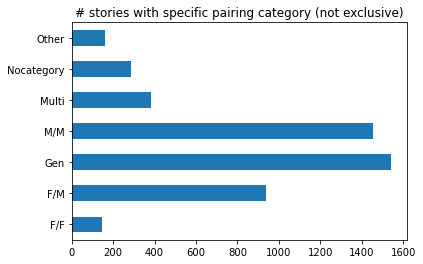

In [58]:
dummy_pairings.sum(axis = 0, skipna = True).plot(kind = "barh", title = "# stories with specific pairing category (not exclusive)");

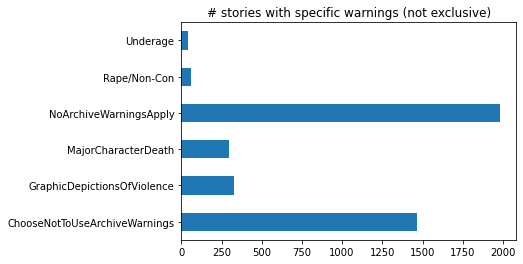

In [59]:
dummy_warnings.sum(axis = 0, skipna = True).plot(kind = "barh", title = "# stories with specific warnings (not exclusive)");

In [60]:
dummy_warnings.head()

,ChooseNotToUseArchiveWarnings,GraphicDepictionsOfViolence,MajorCharacterDeath,NoArchiveWarningsApply,Rape/Non-Con,Underage
0,0,0,0,1,0,0
2,0,0,0,1,0,0
4,0,0,0,1,0,0
9,0,0,1,0,0,0
11,0,0,0,1,0,0


Now the two resulting dataframes from the respective series can be merged to the original dataframe and the two original columns dropped.

In [61]:
df = pd.concat([df, dummy_pairings, dummy_warnings], axis = 1)

In [62]:
df = df.drop(columns = ["pairings", "warnings"])

Because the method str.get_dummies() actually performs one-hot encoding and not dummy encoding. Therefore, the variable 'Choose Not to Use Archive Warnings' and 'Other' will be dropped to avoid redundancy in the ML model. These two of the few values for pairings and warnings that are exclusive.

In [63]:
df = df.drop(columns = ["ChooseNotToUseArchiveWarnings", "Nocategory"])

As for the remaining variables, because they are not part of the same string and the only feature left ('ratings') takes only exclusive values, it can be dummy-encoded easily.

In [64]:
df = pd.get_dummies(df, columns = features_to_encode, drop_first = True)

In [65]:
df.head(10)

,ids,dates_completion,word_counts,n_chapters,n_kudos,languages,n_hits,betweenness_centrality,closeness_centrality,degree_centrality,...,Other,GraphicDepictionsOfViolence,MajorCharacterDeath,NoArchiveWarningsApply,Rape/Non-Con,Underage,ratings_General Audiences,ratings_Mature,ratings_Not Rated,ratings_Teen And Up Audiences
0,102813,1988-11-10,208,1,9,English,423,0.000000e+00,0.487259,0.014679,...,0,0,0,1,0,0,1,0,0,0
2,546730,1995-01-01,1326,1,2,English,152,0.000000e+00,0.494992,0.018611,...,0,0,0,1,0,0,1,0,0,0
4,133466,1995-05-28,494,1,<NA>,English,183,7.039343e-07,0.509099,0.089122,...,0,0,0,1,0,0,1,0,0,0
9,505914,1996-01-01,20708,7,1,English,212,1.309090e-06,0.495831,0.019921,...,0,0,1,0,0,0,0,0,0,1
11,2691530,2001-11-02,476,1,2,English,564,2.496945e-04,0.555232,0.209961,...,0,0,0,1,0,0,0,0,0,1
13,26389726,2002-02-04,632,1,1,English,13,3.960582e-07,0.552973,0.211533,...,0,0,0,1,0,0,1,0,0,0
15,26206666,2002-02-04,2807,1,3,English,21,1.393104e-05,0.556776,0.223853,...,0,0,0,1,0,0,1,0,0,0
17,11827809,2002-02-04,13379,3,2,English,225,4.714133e-06,0.554020,0.214941,...,0,0,0,0,0,0,0,0,0,1
19,26188156,2002-02-04,1297,1,5,English,78,1.393104e-05,0.556776,0.223853,...,0,0,1,0,0,0,0,1,0,0
21,26275516,2002-02-04,49008,38,4,English,123,3.398170e-04,0.600727,0.339974,...,0,0,0,0,0,0,0,0,0,0


In [66]:
df = df.drop(columns = ["languages"])

##### 3. 3. c. Dates of completion 

The last encoding to perform regards the date of completion of a story.

The following bar charts show that the number of fanfictions completed by year, month and day. Most stories were completed in the past few years and around 2013. There are fewer significant changes for the day and month of completion, though December seems to be particularly favorable to completing a fanfiction, for example.

In [67]:
df["day_completion"] = df["dates_completion"].dt.day
df["month_completion"] = df["dates_completion"].dt.month
df["year_completion"] = df["dates_completion"].dt.year

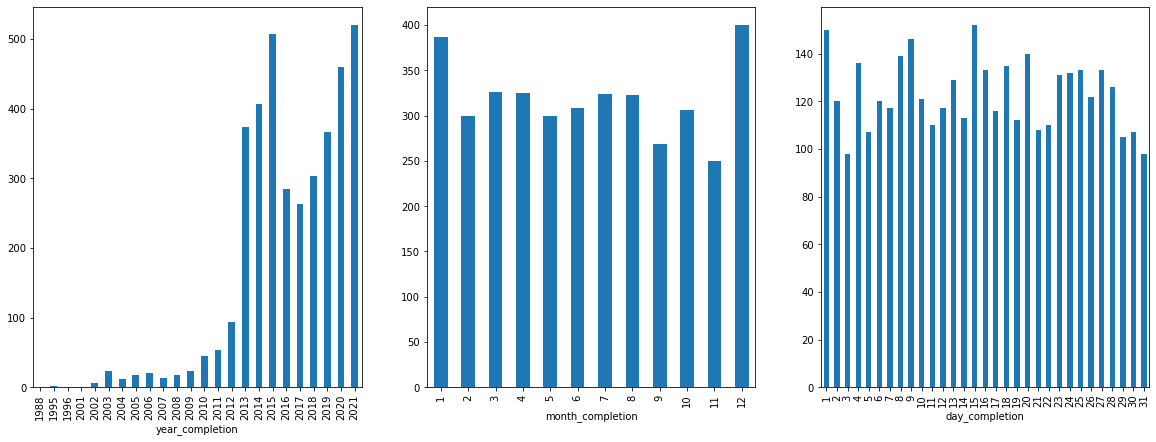

In [68]:
fig, axs = plt.subplots(figsize = (20, 7), nrows = 1 , ncols= 3)
df["ids"].groupby(df["year_completion"]).count().plot(kind = "bar", ax = axs[0])
df["ids"].groupby(df["month_completion"]).count().plot(kind = "bar", ax = axs[1])
df["ids"].groupby(df["day_completion"]).count().plot(kind = "bar", ax = axs[2]);

Out of these three variable, year will be treated as a standard numerical one, while day and month as a cyclical value. Therefore, they need to be encoded twice according to their sine and cosine.

In [69]:
cyclical_features = ["day_completion", "month_completion"]
cyclical = CyclicalTransformer(variables = cyclical_features, drop_original = False)
df = cyclical.fit_transform(df)
df = df.drop(columns = "dates_completion")

### 4. ML model

#### 4.1. Correlation & Data Preparation

it it possible to quickly check if there's any apparent linear correlation among numerical variables (pairwise only). For the sake of this limited analysis, it will be merely enough to identify apparent linear correlations. Further analysis of other correlations and/or further testing over the correlations performed is not conducted on this occasion.

The results from this analysis will serve to understand whether to take into account, for example, the relationship between the number of kudos and number of chapters or the word count when defining the success of a fanfiction. 

In [70]:
numerical_features = ["word_counts", "n_chapters", "n_kudos", "n_hits", "betweenness_centrality", "closeness_centrality", "degree_centrality", "eigenvector_centrality", "crossover_fandoms", "year_completion"]

In [71]:
corr_matrix = df[numerical_features].corr()

In [72]:
corr_matrix

,word_counts,n_chapters,n_kudos,n_hits,betweenness_centrality,closeness_centrality,degree_centrality,eigenvector_centrality,crossover_fandoms,year_completion
word_counts,1.000000,0.552736,0.201412,0.305095,0.122593,0.128665,0.138204,0.124893,0.063999,0.105860
n_chapters,0.552736,1.000000,0.157070,0.309289,0.204707,0.176800,0.180930,0.160908,0.259520,0.088484
n_kudos,0.201412,0.157070,1.000000,0.849965,0.061509,0.109911,0.120251,0.131699,0.045709,-0.006316
n_hits,0.305095,0.309289,0.849965,1.000000,0.101850,0.119202,0.129640,0.146265,0.102909,-0.031083
betweenness_centrality,0.122593,0.204707,0.061509,0.101850,1.000000,0.618850,0.629821,0.501642,0.384903,0.038296
closeness_centrality,0.128665,0.176800,0.109911,0.119202,0.618850,1.000000,0.932195,0.870366,0.280341,0.171015
degree_centrality,0.138204,0.180930,0.120251,0.129640,0.629821,0.932195,1.000000,0.947759,0.304341,0.193185
eigenvector_centrality,0.124893,0.160908,0.131699,0.146265,0.501642,0.870366,0.947759,1.000000,0.239552,0.116483
crossover_fandoms,0.063999,0.259520,0.045709,0.102909,0.384903,0.280341,0.304341,0.239552,1.000000,0.090763
year_completion,0.105860,0.088484,-0.006316,-0.031083,0.038296,0.171015,0.193185,0.116483,0.090763,1.000000


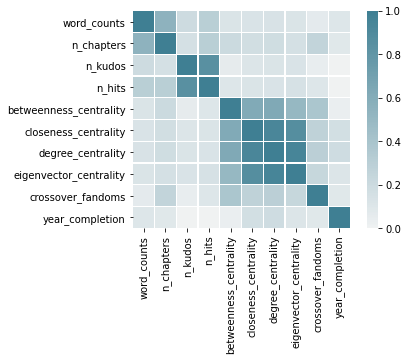

In [73]:
cmap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(corr_matrix, cmap = cmap, center = 0, square = True, linewidths = .3, vmax = 1.0, vmin = 0.0);

Most significantly, there appears to be linear correlation between:

- 'word_counts' and 'n_chapters';

- 'word_counts' and 'n_hits';

- 'n_chapters' and 'n_hits';

- 'n_kudos' and 'n_hits'.

Moreover, the position within the fanfiction network of a story does not seem to be related to any variable save for, to a small degree, the number of crossover fandoms.

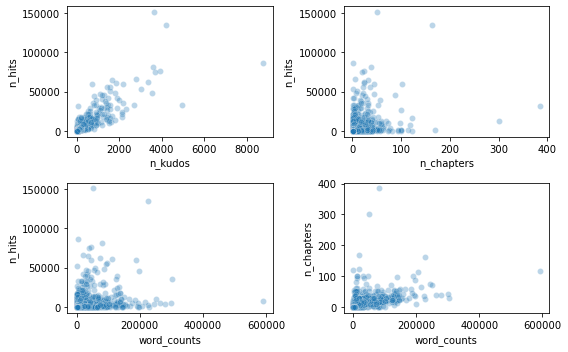

In [74]:
fig, axs = plt.subplots(figsize = (8, 5), nrows = 2, ncols = 2)
sns.scatterplot(ax = axs[0,0], x = df["n_kudos"], y = df["n_hits"], alpha = .3)
sns.scatterplot(ax = axs[0,1], x = df["n_chapters"], y = df["n_hits"], alpha = .3)
sns.scatterplot(ax = axs[1,0], x = df["word_counts"], y = df["n_hits"], alpha = .3)
sns.scatterplot(ax = axs[1,1], x = df["word_counts"], y = df["n_chapters"], alpha = .3)
fig.tight_layout()

All these scatter plots show a high density of data points and some outliers with a very strong variance. If one focuses on the number of kudos and tries to plot it in relation to the other metadata of the story, one sees again a few outliers and the general lack of a linear relation between the number of kudos and these metadata fields.

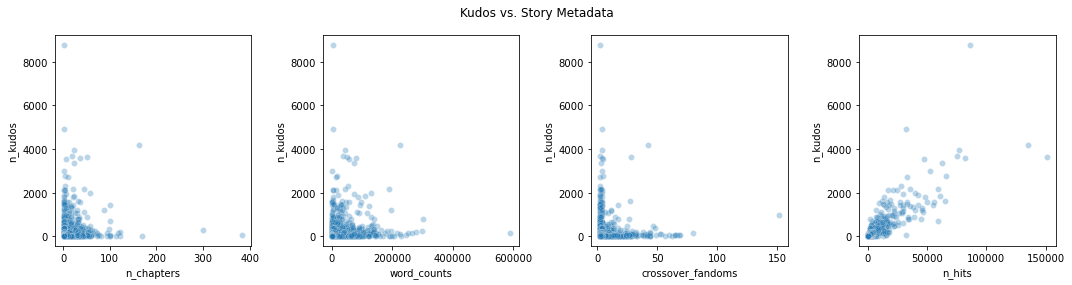

In [75]:
fig, axs = plt.subplots(figsize = (15, 4), nrows = 1, ncols = 4)
features_to_corr_kudos = ["n_chapters", "word_counts", "crossover_fandoms", "n_hits"]
for feature, i in zip(features_to_corr_kudos, range(len(axs))):
    sns.scatterplot(x = df[feature], y = df["n_kudos"], ax = axs[i], alpha = .3)
plt.suptitle("Kudos vs. Story Metadata")
fig.tight_layout();

Overall, linear correlation does not seem to be a significant relationship between the numerical variables in the dataset. However, this does not mean that other types of relations exist within the dataset, which would become apparent with further analysis.

Now it remains to finally define the success of a fanfiction, based on the stats of the 'n_kudos' feature (excluding the NaN values imputed in the next step). Given that 'n_kudos' does not seem to have a strong correlation with any other feature such as 'n_chapters' or 'word_counts', 

In [76]:
df["n_kudos"].describe()

count    3640.000000
mean      105.393132
std       319.704279
min         1.000000
25%        10.000000
50%        32.000000
75%        85.250000
max      8784.000000
Name: n_kudos, dtype: float64

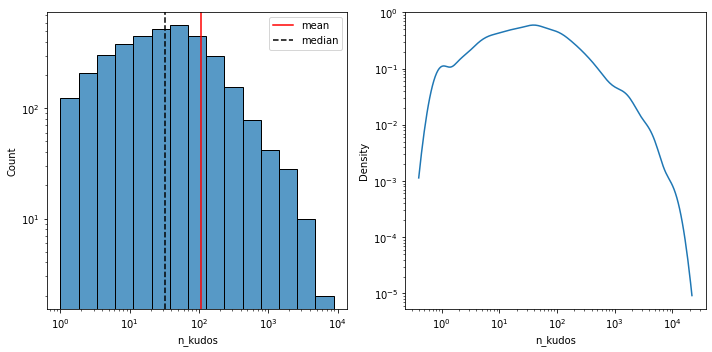

In [77]:
fig, axs = plt.subplots(figsize = (10, 5), nrows = 1, ncols = 2)
plt.sca(axs[0])
sns.histplot(df["n_kudos"], log_scale = (True, True), ax = axs[0], bins = 15)
plt.axvline(x = df["n_kudos"].mean(), c = "r", label = "mean")
plt.axvline(x = df["n_kudos"].median(), c = "k", linestyle = "--", label = "median")
plt.legend()
sns.kdeplot(df["n_kudos"], log_scale = (True, True), ax = axs[1])
plt.tight_layout();

The first step is to remove outliers from the dataset by using IQR. At the same time, it is possible to eliminate 'NaN' values.

In [78]:
def remove_outliers_iqr_mask(df, column_name):
    q1 = np.quantile(df[column_name].dropna(), .25)
    q3 = np.quantile(df[column_name].dropna(), .75)
    iqr = q3 - q1
    mask = ((df[column_name]>= q1) & (df[column_name] <= q3))
    df_masked = df.loc[mask]
    return df_masked

In [79]:
df_iqr_filtered = remove_outliers_iqr_mask(df, "n_kudos")

Following this operation, the size of the dataset has shrunken significantly.

In [80]:
df_iqr_filtered.shape

(1838, 32)

In [81]:
df_iqr_filtered["n_kudos"].describe()

count    1838.000000
mean       35.430359
std        20.480013
min        10.000000
25%        18.000000
50%        31.000000
75%        48.000000
max        85.000000
Name: n_kudos, dtype: float64

Now it is possible to label each entry according to its success. Because this is a very simple ML model, the classification will be binary: 

- 'success' = 0 for an unsuccesful fanfiction; 


- 'success' = 1 for a succesful fanfiction.

The threshold is set to the mean of 'n_kudos', i.e., 35 (rounded up).

In [82]:
def label_success(row):
    if row["n_kudos"] > 35:
        success = 1
    else:
        success = 0
    return success

In [83]:
df_iqr_filtered["success"] = df_iqr_filtered.apply(label_success, axis = 1) # might give warning

<ipython-input-83-c90d4cdd7d2b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iqr_filtered["success"] = df_iqr_filtered.apply(label_success, axis = 1) # might give warning


In [84]:
# alternative in case the warning pops up
df.loc[df["n_kudos"] > 35, "success"] = 1
df.loc[df["n_kudos"] <= 35, "success"] = 0

In [85]:
df_iqr_filtered.head()

,ids,word_counts,n_chapters,n_kudos,n_hits,betweenness_centrality,closeness_centrality,degree_centrality,eigenvector_centrality,crossover_fandoms,...,ratings_Not Rated,ratings_Teen And Up Audiences,day_completion,month_completion,year_completion,day_completion_sin,day_completion_cos,month_completion_sin,month_completion_cos,success
25,85750,2712,1,14,417,0.000095,0.506524,0.036959,0.000985,5,...,0,1,25,6,2002,-0.937752,0.347305,1.224647e-16,-1.000000,0
30,4211760,99578,20,39,1562,0.000002,0.548825,0.204194,0.010584,2,...,0,0,14,7,2002,0.299363,-0.954139,-5.000000e-01,-0.866025,1
34,5104,77,1,25,541,0.000340,0.600727,0.339974,0.013598,4,...,0,0,20,1,2003,-0.790776,-0.612106,5.000000e-01,0.866025,0
38,73651,6472,5,12,329,0.000015,0.479220,0.008912,0.000117,2,...,0,0,3,2,2003,0.571268,0.820763,8.660254e-01,0.500000,0
42,760059,1614,1,26,1209,0.000273,0.599119,0.334731,0.018537,11,...,0,0,8,2,2003,0.998717,-0.050649,8.660254e-01,0.500000,0


Now that it is clear that from now on the 'ids' of the stories won't ever be used again in the analysis, the column can be dropped because it has no significance in predicting the success of a fanfiction. Moreover, the target variable should be removed ('n_kudos') to test whether the the model can actually predict the success based on other factors.

In [86]:
df_iqr_filtered = df_iqr_filtered.drop(columns = ["ids", "n_kudos", "n_hits"])

#### 4.2. ML Classification algorithms

Given the few insights gained above, it is very possible that a linear classifier will perform worse than a non-linear classifier in determining the success of a fanfiction. 

A number of ML algorithms have been tested below: logistic regression as a linear classifier, random forest as a non-linear classifier and K-neighbors and support vector classifier for distance-based classifiers. Because the features in the dataset have not been scaled, it is expected that algorithms such as K-Neighbors Classifier and Support Vector Classifier will probably result in lower accuracy scores because they are distance-based.

First, the data will be split into the training and test sets.

In [87]:
X = df_iqr_filtered.loc[:, "word_counts": "month_completion_cos"]
y = df_iqr_filtered.loc[:, "success"]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 5) 

LogisticRegression accuracy score: 0.5706521739130435


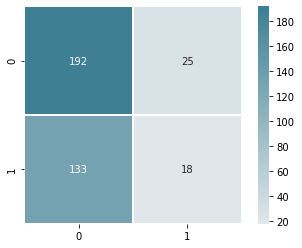

In [89]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print("LogisticRegression accuracy score: {}". format(logistic.score(X_test, y_test)))
y_predict_logistic = logistic.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_predict_logistic), annot = True, fmt = 'd', linewidths = .2, square = True, cmap = cmap, center = 0);

RandomForestClassifier accuracy score: 0.6521739130434783


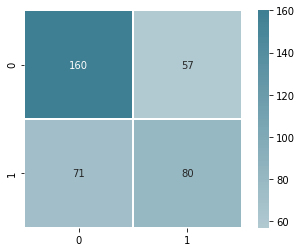

In [90]:
rand_tree = RandomForestClassifier()
rand_tree.fit(X_train, y_train)
print("RandomForestClassifier accuracy score: {}".format(rand_tree.score(X_test, y_test)))
y_predict_rand_tree = rand_tree.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_predict_rand_tree), annot = True, fmt="d", linewidths = .2, square = True, cmap = cmap, center = 0);

KNeighborsClassifier accuracy score: 0.5190217391304348


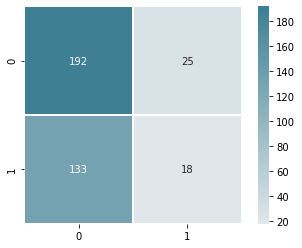

In [91]:
neighbour_class = KNeighborsClassifier(n_neighbors = 3)
neighbour_class.fit(X_train, y_train)
print("KNeighborsClassifier accuracy score: {}".format(neighbour_class.score(X_test, y_test)))
y_predict_neighbour = neighbour_class.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_predict_logistic), annot = True, fmt="d", linewidths = .2, square = True, cmap = cmap, center = 0);

Support Vector Classifier accuracy score: 0.5896739130434783


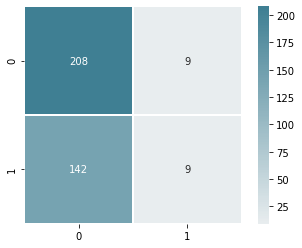

In [92]:
svc = SVC()
svc.fit(X_train, y_train)
print("Support Vector Classifier accuracy score: {}".format(svc.score(X_test, y_test)))
y_predict_svc = svc.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_predict_svc), annot = True, fmt="d", linewidths = .2, square = True, cmap = cmap, center = 0);

### 5. Conclusions

In this notebook, a scraper for AO3 was implemented and a sample dataset analyzed in order to make guesses and experiment with crude feature engineering for ML while exploring the dataset. The greatest challenges of analyzing fanfiction data from AO3 in this notebook have been the following:

- the high number of non-standardized categorical values that metadata fields take;
- defining success solely on the basis of kudos, due to the high number of NaN values for other relevant fields;
- the non-linear relationships between numerical variables.

As a result, this notebook raised more questions than provided any answers or conclusions. The only provisional conclusions to be drawn about the dataset are the following:

- the number of hits is (perhaps quite obviously) correlated to the number of kudos. This variable is probably also leading the linear classification model to good results;
- in order to build an ML model predicting the success of a fanfiction, a non-linear model would be the safest choice.

This basic ML model clearly needs improvement. Overall, the exact reasons behind why the RandomForestClassifier performs as it does, are not so clear. Despite the relatively high score with this classifier, by applying more solid feature engineering methods and more correlation analysis, the result should definitely improve. 

For example, in this notebook there was no attempt to analyze the relationship between categorical variables and success of a fanfiction (if there's a relation at all between them), nor the relationbetween the story's position within the network was thoroughly explored (though it did not seem to correlate to the number of kudos at a first glance). 

Completion dates, despite being encoded in the ML model, have also not been analyzed properly with regards to the success of a fanfiction. 

More rigorous methods of imputing (disregarded in favour of simply dropping NaN values) and feature scaling should help in address the limits of this analysis.